# Capstone 2 - EDA

## Title: Yelp business insights and hybrid restaurant recommender system

## Executive Summary



## 1. Introduction

### 1.1 Problem

<p>Nowadays recommender systems are everywhere. Almost every major tech company has applied them in some form or another: Amazon uses it to suggest products to customers, and YouTube uses it to decide which video to play next on autoplay. In fact, one fundamental driver of data science’s skyrocketing popularity is the overwhelming amount of information available for anyone trying to make a good decision, and a recommender system helps to filter vast amount of information and make suggestions according to individual’s preference.</p> 

<p>Yelp is one of those companies whose business success relies heavily on the power of its recommender system. It provides users coming to their website or app with quick suggestions of nearby businesses or a list of suggestions for businesses matching users’ search keywords and location. While yelp provides ratings for each business, these are not always indicative of a restaurant’s quality. For instance, a restaurant with only one rating of 5-stars would be ranked higher than a restaurant with a hundred ratings averaging 4.8 stars. Other problems include that the star rating varies from person to person, and the older ratings are less relevant. Improvements are needed to provide better ratings and suggestions.</p>

<p>In this project, a hybrid recommender system will be developed featuring following capabilities: 1) for new or anonymous users, the recommendation engine can provide base-case recommendations using location information and/or other keywords. 2) with user ID as input and user’s interactive feedback, either the collaborative filtering or the content-based filtering will be used to provide personalized recommendations from user’s activity history. 3) smart weighted ratings will be computed taking into consideration the total number of ratings and the irrelevance of outdated ratings etc.</p>

### 1.2 Dataset
The Yelp dataset is available to the public via Yelp Dataset Challenge. The dataset is available for download upon signing up at https://www.yelp.com/dataset. The raw data is structured as five individual JSON files contains a total of 5,996,996 reviews, 1,518,169 users, 188,593 businesses, 1,185,348 tips, and over 1.4 million business attributes for each of the 188,593 businesses. The raw dataset is downloaded as JSON files, converted to csv files, cleaned up and saved.

### 1.3 The questions of interest
The goal of EDA is to understand the dataset and find interesting business and user patterns: <br> 
- popular restaurant cuisines by locations; <br> 
- popular restaurant styles by location; <br>
- highly rated restaurants by cost; <br>
- correlation between ratings and reviews; <br>

These understanding will also help in designing the recommendation engine. 

### 1.4 Interactive visualization
Interactive data visualizations are created using bokeh based on EDA findings.<br>

## 2. import the clean dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# import all five csv files as Pandas dataframe

business = pd.read_csv('business_clean.csv')  # contains business data including location data, attributes and categories
user = pd.read_csv('user_clean.csv') # contains users data including the user's friend mapping and all the metadata associated with the user
review = pd.read_csv('review_clean.csv') # contains full review text data including the user_id that wrote the review and the business_id the review is written for
tip = pd.read_csv('tip_clean.csv') # tips written by a user on a business, tips are shorter than reviews and tend to convey quick suggestions
checkin = pd.read_csv('checkin_clean.csv') # checkins on a business

## 3. Understand business pattern

### 3.1 Common restaurants

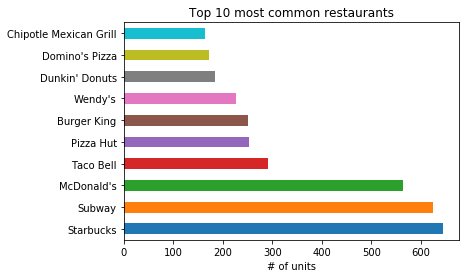

In [3]:
# ten most common restaurant names
business.name.value_counts()[:10].plot(kind='barh');
plt.xlabel('# of units');
plt.title('Top 10 most common restaurants');

As expected, top 10 most common restaurants are the popular chain or franchised restaurants, fast food or coffee shops.

### 3.2 Restaurants statistics by state

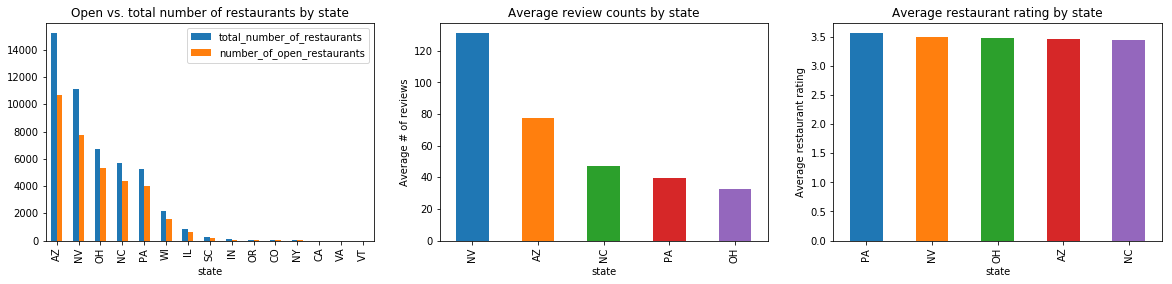

In [4]:
plt.figure(figsize=(20,4))

# total number of restaurants vs open restaurants by state
ax1 = plt.subplot(1,3,1)
open_by_state = business.groupby('state')['is_open'].agg(['count','sum']).sort_values(by=['count'],ascending=False)
open_by_state.columns = ['total_number_of_restaurants','number_of_open_restaurants']
open_by_state.plot(kind='bar',ax=ax1);
ax1.set_title('Open vs. total number of restaurants by state');

# create a groupby object based on the top five states
groupby_5state = business[business.state.isin(['AZ','NV','OH','NC','PA'])].groupby('state')

# average review_count by state for top five states
ax2 = plt.subplot(1,3,2)
groupby_5state['review_count'].mean().sort_values(ascending=False).plot(kind='bar', ax=ax2);
ax2.set_ylabel('Average # of reviews');
ax2.set_title('Average review counts by state');

# average rating by state for top five states
ax3 = plt.subplot(1,3,3)
groupby_5state['stars'].mean().sort_values(ascending=False).plot(kind='bar', ax=ax3);
ax3.set_ylabel('Average restaurant rating');
ax3.set_title('Average restaurant rating by state');

As shown, this dataset only contains a subset of all yelp businesses, focused on businesses from only a few selected states. In terms of restaurants, only a portion of restaurants from 15 states (Arizona, Nevada, Ohio, North Carolina, Pennsylvania, Wisconsin, Illinois, South Carolina, Indiana, Oregon, Colorado, New York, California, Vermont and Virgina) are available in this dataset. Among them, only Arizona, Nevada, Ohio, North Carolina and Pennsylvania have a rich catalog of over 5000 restaurants, and will be the main focus of this project. 

In terms of review counts, Nevada has a much higher average than all others, as a result of the popularity of Las Vegas as a resort town. The average restaurant rating is very similar among five states, close to 3.5.

### 3.3 Restaurant rating vs. review

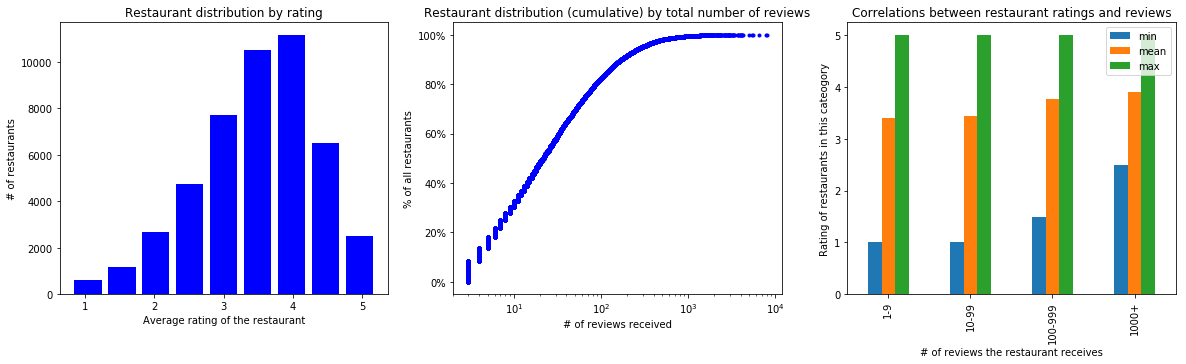

In [5]:
plt.figure(figsize=(20,5))

# restaurant distribution by rating
ax1 = plt.subplot(1,3,1)
business.stars.plot(kind='hist', bins=9, range=(0.8, 5.2), rwidth=0.8, color = 'blue', ax=ax1);
ax1.set_xlabel('Average rating of the restaurant');
ax1.set_ylabel('# of restaurants');
ax1.set_title('Restaurant distribution by rating');

# restaurant distribution by review counts
def ecdf(array):
    """Compute ECDF for 1D array of measurement data."""
    x = np.sort(array)  #sort array to use as the x axis    
    y = np.arange(1, len(array)+1)/len(array) #use np.arange to create the y axis for cdf from 1/len to 1
    return x,y

ax2 = plt.subplot(1,3,2)
x,y = ecdf(business.review_count)
ax2.plot(x, y, marker = '.', linestyle='none',color='blue');
ax2.set_yticklabels(['{:.0%}'.format(x) for x in ax2.get_yticks()])
ax2.set_xscale('log');
ax2.set_xlabel('# of reviews received');
ax2.set_ylabel('% of all restaurants');
ax2.set_title('Restaurant distribution (cumulative) by total number of reviews');

# correlation between rating and review
ax3 = plt.subplot(1,3,3)
count_cat = np.log10(business.review_count)//1
busi_by_rev_count = business.groupby(count_cat)['stars'].agg(['min','mean','max'])
busi_by_rev_count.index = ['1-9','10-99','100-999','1000+']
busi_by_rev_count.plot(kind='bar', ax=ax3);
ax3.set_xlabel('# of reviews the restaurant receives');
ax3.set_ylabel('Rating of restaurants in this cateogory');
ax3.set_title('Correlations between restaurant ratings and reviews');

As shown, the majority of the restaurants have a rating between 3.0 and 4.5, with 3.5 and 4.0 being the most common ratings. Half of the restaunrants have less than 30 reviews, although the record number of reviews is as high as 7968.
The correlation between ratings and reviews reveals that restaurants with more reviews tend to have higher ratings on average.

### 3.4 Restaurants by price range

In [6]:
# variation of rating and review_count with price_range
rest_by_price = business.groupby(business['attributes.RestaurantsPriceRange2'])['business_id','stars','review_count'].agg({'business_id': 'count','stars':'mean','review_count':['mean','max']})
rest_by_price.index = ["$ (low)","$$ (mid)","$$$ (high)","\$$$$ (highest)"]
rest_by_price.index.name = 'RestaurantPriceRange'
rest_by_price

business_id     stars review_count      
                           count      mean         mean   max
RestaurantPriceRange                                         
$ (low)                    19450  3.450026    49.021285  4981
$$ (mid)                   19765  3.516848   104.397369  7968
$$$ (high)                  1615  3.557585   172.191331  7866
\$$$$ (highest)              320  3.526562   186.746875  3244

As shown, most restaurants are in the low (40.9%) and mid (41.6%) price range, whereas restaurants in the high and highest price ranges only account for 3.4% and 0.67%, respectively. In addition, there are 13.5% of restaurants having missing price range data. 

In terms of ratings ('stars'), restaurants in different price ranges have relatively close average ratings of around 3.5. 
In terms of the # of reviews received ('review_count'), more expensive restaurants tend to receive more reviews on average.

In [7]:
# top reviewed restaurants by price range

print("Top 3 restaurants of all:")
print(business[['stars','review_count','name','state','city','attributes.RestaurantsPriceRange2']].sort_values(['stars','review_count'],ascending=False)[0:3])

print("-------------------------")
print("Top 3 restaurants in the most expensive price range ($$$$):")
print(business[business['attributes.RestaurantsPriceRange2'] == 4][['stars','review_count','name','state','city']].sort_values(['stars','review_count'],ascending=False)[0:3])

print("-------------------------")
print("Top 3 restaurants in the high price range ($$$):")
print(business[business['attributes.RestaurantsPriceRange2'] == 3][['stars','review_count','name','state','city']].sort_values(['stars','review_count'],ascending=False)[0:3])

print("-------------------------")
print("Top 3 restaurants in the mid price range ($$):")
print(business[business['attributes.RestaurantsPriceRange2'] == 2][['stars','review_count','name','state','city']].sort_values(['stars','review_count'],ascending=False)[0:3])

print("-------------------------")
print("Top 3 restaurants in the low price range ($):")
print(business[business['attributes.RestaurantsPriceRange2'] == 1][['stars','review_count','name','state','city']].sort_values(['stars','review_count'],ascending=False)[0:3])

Top 3 restaurants of all:
       stars  review_count             name state       city  \
7464     5.0          1746  Little Miss BBQ    AZ    Phoenix   
31910    5.0          1380     Brew Tea Bar    NV  Las Vegas   
45401    5.0           547       Gelatology    NV  Las Vegas   

       attributes.RestaurantsPriceRange2  
7464                                 2.0  
31910                                1.0  
45401                                1.0  
-------------------------
Top 3 restaurants in the most expensive price range ($$$$):
       stars  review_count                        name state       city
36062    5.0           133                Kame Omakase    NV  Las Vegas
15661    5.0            51        Binkley's Restaurant    AZ    Phoenix
12668    5.0            17  Rise Craft Coffee + Eatery    AZ    Phoenix
-------------------------
Top 3 restaurants in the high price range ($$$):
       stars  review_count                     name state       city
45502    5.0            36 

### 3.5 Restaurants by cuisine and style

In [8]:
# define a default list for restaurant cuisines and restaurant styles

cuisines = ['mexican','italian','chinese','japanese','thai','indian','american (new)','american (traditional)','french',\
            'middle eastern','korean','mediterranean','vietnamese','cajun','greek','hawaiian','asian fusion','vegetarian',\
            'vegan','steakhouse','barbeque','sushi bars','tex-mex','specialty food','gluten-free','coffee & tea','desserts',\
            'seafood','ice cream & frozen yogurt','bakeries','beer','wine & spirits','soup','pizza','hot dogs','burgers','donuts',\
            'cupcakes','salad','tacos','chicken wings','sandwiches','bubble tea','tapas/small plates','shaved ice','bagels',\
            'southern','local flavor','latin american','custom cakes','ethinic food']

styles = ['restaurants','fast food','food stands','street vendors','nightlife','buffets','bars','food trucks','breakfast & brunch','diners','cocktail bars',\
          'pubs','sports bars','wine bars','beer bars','casinos','juice bars & smoothies','caterers','delis','cafes','lounges',\
          'music venues','performing arts','food delivery services','dive bars','dance clubs','breweries']

In [9]:
# extract cuisine and style information from the 'categories' columns

business['cuisine'] = None
business['style'] = None

for idx, row in business.iterrows():
    if row['categories'] is not np.nan:
        entries = row['categories'].split(',')
        for entry in entries:
            entry = entry.strip().lower()
            if entry in cuisines: 
                if business.loc[idx,'cuisine'] == None: 
                    business.loc[idx,'cuisine'] = entry
                else:
                    business.loc[idx,'cuisine'] += (', ' + entry)
            elif entry in styles:
                if business.loc[idx,'style'] == None:
                    business.loc[idx,'style'] = entry
                else:
                    business.loc[idx,'style'] += (', ' + entry)

business.fillna(value=pd.np.nan, inplace=True) # update None with NaN

In [10]:
# define function for returning top n phrases from a dataframe's column
from collections import Counter

def top_n_from_column(df, col, n):
    """Take a Dataframe and a column name, return the top n phrases (case insensitive) in that column
    Note: column needs to contain a string of phrases separated by comma.
    """
    counter = Counter()
    for idx, row in df.iterrows():
        if row[col] is not np.nan: 
            entries = row[col].split(',')
            for entry in entries:
                entry = entry.strip().lower()
                counter[entry] += 1    
    return counter.most_common(n)

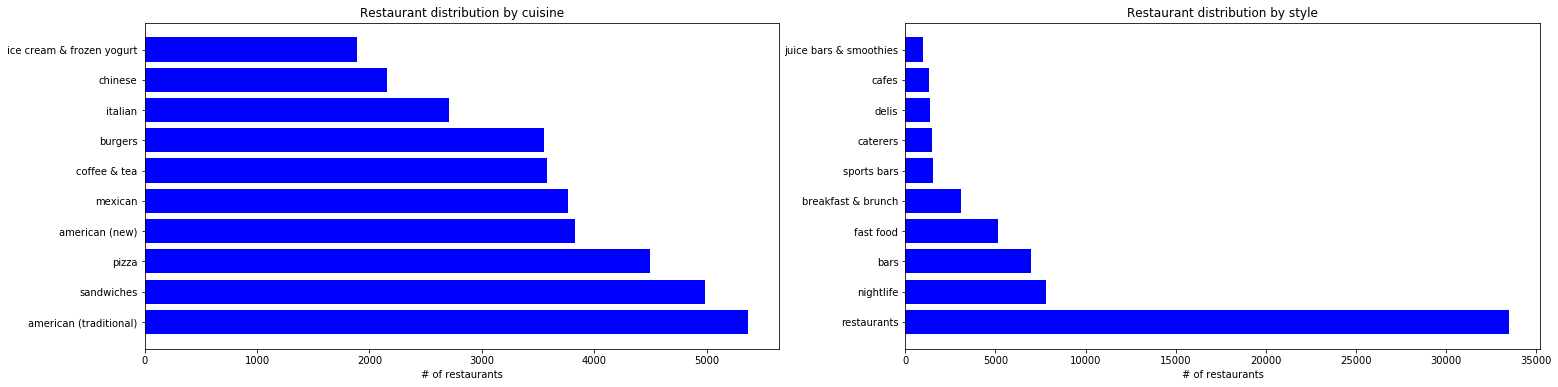

In [11]:
# plot restaurant by cuisine and style

plt.figure(figsize=(25,6))

# restaurant by cuisine
ax1 = plt.subplot(1,2,1)
top_cuisine = top_n_from_column(business, 'cuisine', 10)
ax1.barh(y=[x[0] for x in top_cuisine], width=[x[1] for x in top_cuisine],color='blue');
ax1.set_xlabel('# of restaurants');
ax1.set_title('Restaurant distribution by cuisine');

# restaurant by style
ax2 = plt.subplot(1,2,2)
top_style = top_n_from_column(business,'style',10)
ax2.barh(y=[x[0] for x in top_style], width=[x[1] for x in top_style],color='blue');
ax2.set_xlabel('# of restaurants');
ax2.set_title('Restaurant distribution by style');

As shown, the most popular cuisine among all is American style (traditional and new), followed by Mexican, Italian and Chinese. The most popular restaurant setting is the formal restaurant style, followed by the nightlife/bar style and fast food.

## 4. Understand user pattern

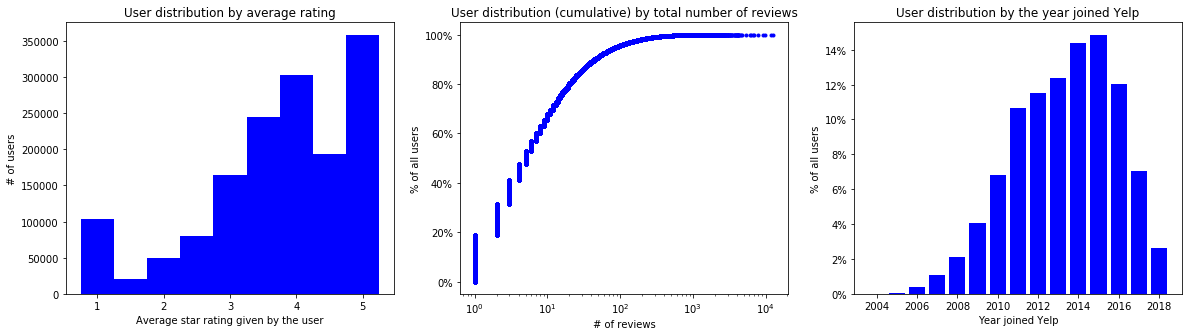

In [12]:
plt.figure(figsize=(20,5))

# user distribution by average star rating
ax1 = plt.subplot(1,3,1)
user.average_stars.plot(kind='hist',bins=9, range=(0.75,5.25),color='blue',ax=ax1);
ax1.set_xlabel('Average star rating given by the user');
ax1.set_ylabel('# of users');
ax1.set_title('User distribution by average rating');

# user distribution by total number of reviews
x, y = ecdf(user.review_count)
ax2 = plt.subplot(1,3,2)
ax2.plot(x, y, marker = '.', linestyle='none',color='blue');
ax2.set_yticklabels(['{:.0%}'.format(x) for x in ax2.get_yticks()])
ax2.set_xscale('log');
ax2.set_xlabel('# of reviews');
ax2.set_ylabel('% of all users');
ax2.set_title('User distribution (cumulative) by total number of reviews');

# user distribution by the year they joined Yelp
import re
yr_joined = user.yelping_since.apply(lambda x: re.findall('^\d{4}',x)[0]).astype(int) # extract the year from the date string
ax3 = plt.subplot(1,3,3)
yr_joined.plot(kind='hist',density=True,bins=15,range=(2003.5,2018.5),rwidth=0.8, color='blue',ax=ax3);
ax3.set_yticklabels(['{:.0%}'.format(x) for x in ax3.get_yticks()])
ax3.set_xlabel('Year joined Yelp');
ax3.set_ylabel('% of all users');
ax3.set_title('User distribution by the year joined Yelp');

As shown, most users on Yelp are generous with an average rating of 3+. 60% of the users have less than 10 reviews in total, although the maximum number of reviews a user has is 12723. This suggests that althoug there are very active Yelp users with many reviews, most users post reviews on Yelp only occationally. Yelp witnesses a steady increase of new members since the beginning, and this increase in new users peaks out in 2015, followed by a significant decline afterward.

## 5. Understand reviews and tips

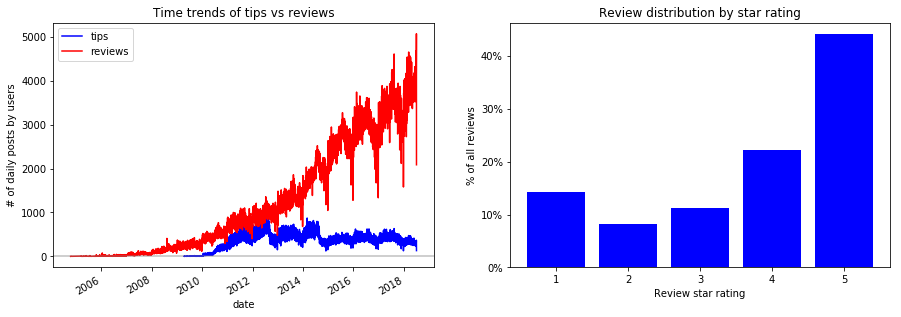

In [13]:
plt.figure(figsize=(15,5))

# plot time trend for daily tips vs daily reviews
ax1 = plt.subplot(1,2,1)
tip['date'] = pd.to_datetime(tip.date, format='%Y-%m-%d')
tip.groupby('date')['text'].count().plot(color='blue', ax=ax1);
review['date'] = pd.to_datetime(review.date, format='%Y-%m-%d')
review.groupby('date')['text'].count().plot(color='red', ax=ax1);

ax1.axhline(y=0, color='grey',alpha=0.5);
ax1.set_ylabel('# of daily posts by users');
ax1.legend(['tips','reviews']);
ax1.set_title('Time trends of tips vs reviews');

# plot review distribution by star rating
ax2 = plt.subplot(1,2,2)
review.stars.plot(kind='hist',density=True, bins=5, range=(0.5,5.5),rwidth=0.8, color='blue', ax=ax2);
ax2.set_yticklabels(['{:.0%}'.format(x) for x in ax2.get_yticks()])
ax2.set_xlabel('Review star rating');
ax2.set_ylabel('% of all reviews');
ax2.set_title('Review distribution by star rating');

As shown, review is one of the earliest feature Yelp has since its beginning, whereas tip is one of the later features introduced in 2009. The popularity of reviews (# of reviews) shows a steady upward trend over time with seasonal fluctuations, whereas the popularity of tips (# of tips) increases in the first four years and slowly dives down afterward. Overall, tip is not as popular as review.<br>
Two thirds of the reviews are associated with a positive star rating of 4+.

## 6. Understand checkins

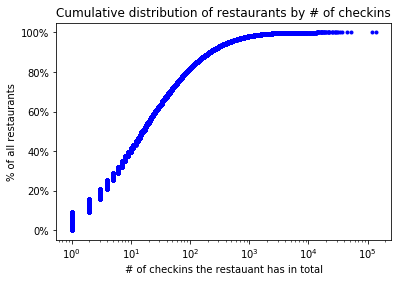

In [14]:
# business distribution by their total number of checkins
x, y = ecdf(checkin.total_count)
ax = plt.subplot()
ax.plot(x, y, marker = '.', linestyle='none', color='blue');
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
plt.xscale('log');
plt.xlabel('# of checkins the restauant has in total');
plt.ylabel('% of all restaurants');
plt.title('Cumulative distribution of restaurants by # of checkins');

Half of the restaurants have less than 20 checkins, even less than the reviews, indicating that checkin is not a widely used feature on Yelp. 

## 7. Interactive visualization using Bokeh

Instructions on embedding a Bokeh server in a Notebook: https://github.com/bokeh/bokeh/blob/1.0.1/examples/howto/server_embed/notebook_embed.ipynb

In [15]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Select, Slider
from bokeh.layouts import row, column, widgetbox
from bokeh.palettes import Category20, Spectral4
from bokeh.transform import factor_cmap
output_notebook()

Loading BokehJS ...

### 7.1 Restaurants by location

In [16]:
# common restaurants by location

def common_rest_by_state(doc):
    names = list(business.name.value_counts()[:10].index)
    counts = business.name.value_counts()[:10].values
    source_common = ColumnDataSource(data=dict(names = names, counts=counts))
    p_common = figure(height = 350, y_range = names, toolbar_location = None, title='Common restaurants in all states')
    p_common.hbar(y='names', left=0, right='counts', source=source_common, height=0.8, 
                  line_color=None, fill_color=factor_cmap('names', palette=Category20[20], factors=names))
    p_common.ygrid.grid_line_color = None
    p_common.x_range.start = 0
    p_common.xaxis.axis_label = '# of units in all states'

    def callback(attr,old,new):
        val = menu.value
        if val == 'all states': df = business
        else: df = business[business.state == val]
        names = list(df.name.value_counts()[:10].index)
        counts = df.name.value_counts()[:10].values
        source_common.data= dict(names = names, counts = counts)
        p_common.y_range.factors = names  # update range for the categorical y-axis
        p_common.title.text = "Common restaurants in {}".format(val)
        p_common.xaxis.axis_label = "# of units in {}".format(val)
    
    menu = Select(value='all states', options=['all states','AZ','NV','NC','OH','PA'], title='State')
    menu.on_change('value', callback)
    layout = row(p_common, menu)
    doc.add_root(layout)
    
show(common_rest_by_state)

In [17]:
# summary statistics by location

by_state = business.groupby('state') 
states = list(by_state.count().index) # list of states
totals = by_state['business_id'].count() # total number of restaurants by state (including both open and closed)
stars = by_state['stars'].mean() # average of star ratings by state
review_counts = by_state['review_count'].mean() # average number of reviews by state
opens = by_state['is_open'].sum() # number of open restaurants by state

def stats_by_state(doc):
    """ Plot various summary statistics by state using interactive visualization via Bokeh server
    """
    
    source_state = ColumnDataSource(data=dict(states=states, y=totals))
    p_state = figure(x_range=states, plot_height=350, toolbar_location=None, title="# of restaurants (total) by state")
    p_state.vbar(x='states', top='y', bottom=0, width=0.8, source=source_state, 
                 line_color= None, fill_color=factor_cmap('states', palette=Category20[15], factors=states))
    p_state.xgrid.grid_line_color = None
    p_state.y_range.start = 0
    p_state.yaxis.axis_label = '# of restaurants (total)'

    def callback(attr,old,new):
        val = menu.value
        if val == "# of restaurants (total)": y = totals
        elif val == "Average rating": y = stars
        elif val == "Average number of reviews": y = review_counts
        else: y = opens
        source_state.data=dict(states=states, y=y)
        p_state.title.text = "{} by state".format(val)
        p_state.yaxis.axis_label = val
    
    menu = Select(value='# of restaurants (total)', title='Summary statistics', 
                  options=['# of restaurants (total)','Average rating','Average number of reviews','# of restaurants (open)'])
    menu.on_change('value',callback)
    layout = row(p_state, menu)
    doc.add_root(layout)
    
show(stats_by_state)

### 7.2 restaurants by price

In [18]:
# summary statistics by price range and by location

def stats_by_price(doc):
    
    # compute statistics by price range
    by_price = business.groupby('attributes.RestaurantsPriceRange2')
    counts = by_price.business_id.count()
    mean_ratings = by_price.stars.mean()    
    mean_rev_cnts = by_price.review_count.mean()
    max_rev_cnts = by_price.review_count.max()
    prices = ["$ (low)","$$ (mid)","$$$ (high)","$$$$ (highest)"]
    
    source_price = ColumnDataSource(data=dict(prices=prices, y=counts))
    p_price = figure(x_range=prices, height=300, width=500, toolbar_location=None, title='# of restaurants by price range for all states')
    p_price.vbar(x='prices', top='y', bottom=0, width=0.8, source=source_price, line_color=None,
                 fill_color=factor_cmap('prices', palette=Spectral4, factors=prices))
    p_price.xgrid.grid_line_color = None
    p_price.y_range.start = 0
    p_price.yaxis.axis_label = '# of restaurants in all states'
    
    def callback(attr, old, new):
        # update according to 'state' menu
        state = menu_1.value
        if state == "all states": df = business
        else: df = business[business.state == state]
        by_price = df.groupby('attributes.RestaurantsPriceRange2')
        counts = by_price.business_id.count()
        mean_ratings = by_price.stars.mean()    
        mean_rev_cnts = by_price.review_count.mean()
        max_rev_cnts = by_price.review_count.max()
        
        # update according to 'Summary statistics' menu
        stats = menu_2.value
        if stats == "# of restaurants": y = counts
        elif stats == "Average rating": y = mean_ratings
        elif stats == "Average # of reviews": y = mean_rev_cnts
        else: y = max_rev_cnts
        
        source_price.data = dict(prices=prices, y=y)
        p_price.title.text = "{} by price range for {}".format(stats, state)
        p_price.yaxis.axis_label = "{} in {}".format(stats, state)
        
    menu_1 = Select(value='all states', options=['all states','AZ','NV','NC','OH','PA'], title='State')
    menu_1.on_change('value', callback)
    menu_2 = Select(value='# of restaurants', title='Summary statistics',
                    options=['# of restaurants','Average rating','Average # of reviews','Maximum # of reviews'])
    menu_2.on_change('value',callback)
        
    layout = row(p_price, column(menu_1, menu_2))
    doc.add_root(layout)

show(stats_by_price)

### 7.3 restaurants by category

In [19]:
# restaurants by category and location
from collections import Counter

def top_n_from_column(df, col, n):
    """Take a Dataframe and a column name, return the top n phrases (case insensitive) in that column
    Note: column needs to contain a string of phrases separated by comma.
    """
    counter = Counter()
    for idx, row in df.iterrows():
        if row[col] is not np.nan: 
            entries = row[col].split(',')
            for entry in entries:
                entry = entry.strip().lower()
                counter[entry] += 1    
    return counter.most_common(n)
    
def rest_by_category(doc):
    
    top_10 = top_n_from_column(business, 'cuisine', 10)
    cuisines = [i[0] for i in top_10]
    counts = [i[1] for i in top_10]
    source_category = ColumnDataSource(data=dict(counts=counts, y=cuisines))
    p_category = figure(y_range=cuisines, height=300, width=600, toolbar_location=None, 
                        title='Top 10 cuisines for restaurants in all states')
    p_category.hbar(y='y', left=0, right='counts', height=0.8, source=source_category, line_color=None,
                 fill_color=factor_cmap('y', palette=Category20[20], factors=cuisines))
    p_category.ygrid.grid_line_color = None
    p_category.x_range.start = 0
    p_category.xaxis.axis_label = '# of restaurants'
    
    def callback(attr, old, new):      
        state = menu_1.value
        cat = menu_2.value
        n = menu_3.value
        
        # update data according to the new selections
        if state == 'all states': df = business
        else: df = business[business.state == state]
        top_n = top_n_from_column(df, cat, n)
        
        y = [i[0] for i in top_n]
        counts = [i[1] for i in top_n]
        source_category.data = dict(counts=counts, y=y) 
        
        p_category.y_range.factors = y  # update range for the categorical y-axis
        p_category.title.text = "Top {} {} for restaurants in {}".format(n, cat, state)
    
    menu_1 = Select(value='all states', options=['all states','AZ','NV','NC','OH','PA'], title='State')
    menu_1.on_change('value',callback)
    menu_2 = Select(value='cuisine', options=['cuisine','style'], title='Category', )
    menu_2.on_change('value',callback)
    menu_3 = Slider(start=5, end=20, step=1, value=10, title='Top n')
    menu_3.on_change('value',callback)
    
    layout = row(p_category, widgetbox(menu_1, menu_2, menu_3))
    doc.add_root(layout)

show(rest_by_category)

### 7.4 Restaurant distribution visualized on map using Bokeh

In [20]:
# Google map API key
api_key = mask

In [21]:
from bokeh.models import GMapOptions
from bokeh.plotting import gmap

output_notebook()

map_options = GMapOptions(lat=36.114647, lng=-115.172813, map_type="roadmap", zoom=3)

p = gmap(api_key, map_options, title="Restaurant distribution by location",
        tools="pan,wheel_zoom,reset")
         
source = ColumnDataSource(data=dict(lat=business.latitude,lon=business.longitude))

p.circle(x="lon", y="lat", size=12, source = source, fill_color="blue", line_color="blue", fill_alpha=0.2)

show(p)

Loading BokehJS ...

### 7.5 Restaurant distribution visualized on map using Folium

In [23]:
import folium

m = folium.Map(location=[36.114647, -115.172813], zoom_start=3.5)

i=0
for idx, row in business.iterrows():  
    if i>1000: break # limit # of markers to 5000, otherwise map is not displaying correctly
    folium.Marker(location = [row.latitude, row.longitude]).add_to(m)
    i += 1
m

### Summary